In [1]:
import os
checkpoint_id = "fed8b8d4-4d62-49a7-a5f0-d9037411c231"
os.chdir(f"/home/christoph/Code/det-gan-research/checkpoints/{checkpoint_id}/code/")

In [2]:
import cv2
import math
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import scipy.ndimage
import numpy as np
import seaborn as sns

from ipywidgets import Video
from tqdm.notebook import tqdm
from determined.experimental import Checkpoint
from models import MsgGenerator
from msg_gan import MsgGANTrail
from utils import sample_noise, adjust_dynamic_range
from distributions import TruncatedNormal

In [3]:
trail = Checkpoint.load_from_path("../", map_location=torch.device('cpu'))

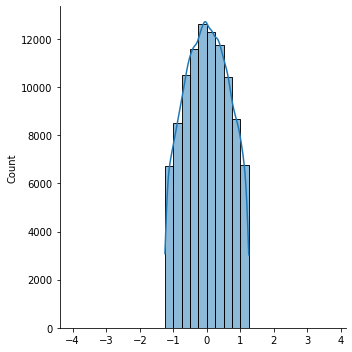

In [4]:
num_images = 6
truncations=(-1.25, 1.25)
noise_size = trail.latent_dimension
z = sample_noise(num_images, noise_size, normalize=False, truncations=truncations)
dist = sample_noise(1, 100000, normalize=False, truncations=truncations).squeeze()

ax = sns.displot(dist, bins=np.arange(-4, 4, 0.25), kde=True)
plt.show()

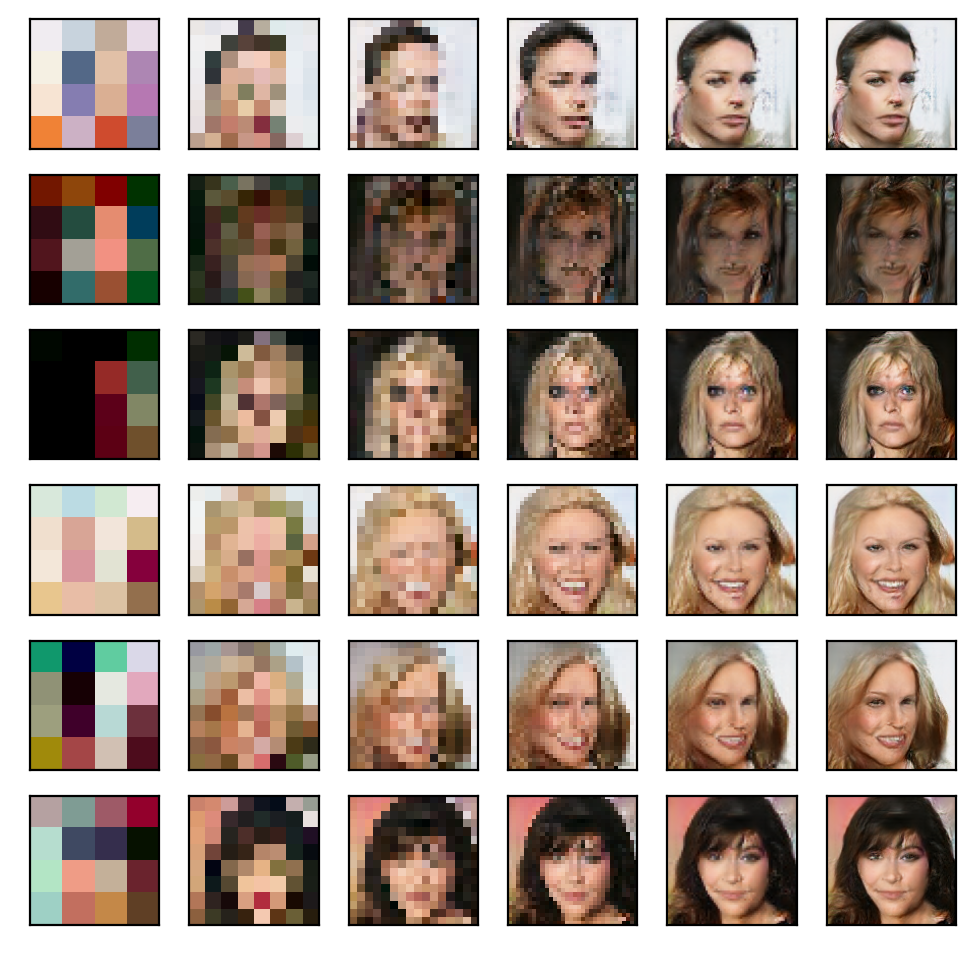

In [5]:
images, w = trail.generator(z)
biggest_size = images[-1].shape[-1]
num_resolutions = int(math.log2(biggest_size))

resolutions, x = trail.generator(z)
fig, axes = plt.subplots(nrows=num_images, ncols=num_resolutions - 1, dpi=200, figsize=(6, 6))


for col, resolution in enumerate(resolutions):
    for row, tensor in enumerate(resolution):
        tensor = tensor.clamp(0, 1)
        # tensor = adjust_dynamic_range(tensor)
        #current_size = tensor.shape[-1]
        
        
        image = transforms.ToPILImage()(tensor.cpu())
        axes[row, col].imshow(image)
        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)

In [6]:
toPILImage = transforms.ToPILImage()

out_dir = "temp"
os.makedirs(out_dir, exist_ok=True)
video_path = 'temp/interpolation.mp4'


time = 60
fps = 30
smoothing = 1.25
total_frames = time * fps

fourcc = cv2.VideoWriter_fourcc(*'VP90')
video = cv2.VideoWriter(video_path, fourcc=fourcc, fps=fps, frameSize=(biggest_size, biggest_size))

all_z = sample_noise(total_frames, noise_size, normalize=False, truncations=truncations)
all_z = scipy.ndimage.gaussian_filter(all_z, [smoothing * fps, 0])
all_z = torch.from_numpy(all_z)

for idx, z in tqdm(enumerate(all_z), desc="Generating video", total=total_frames):
    frame = idx + 1
    z.unsqueeze_(dim=0)
    tensors, w = trail.generator(z)
    tensor = tensors[-1]
    tensor.clamp_(0, 1)
    
    image = toPILImage(tensor.squeeze())
    image = np.array(image)
    image = image[:, :, ::-1].copy() 

    video.write(image)
    
video.release()
Video.from_file(video_path, play=True)

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x006\xaa\x0fmdat\x82I\x…